<a href="https://colab.research.google.com/github/sedatoner/Heatmap-Generation-and-Anomaly-Detection-Using-IR-Thermal-Camera-Data/blob/main/Heatmap_Generation_and_Anomaly_Detection_Using_IR_Thermal_Camera_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage
import pandas as pd
from sklearn.ensemble import IsolationForest
import os

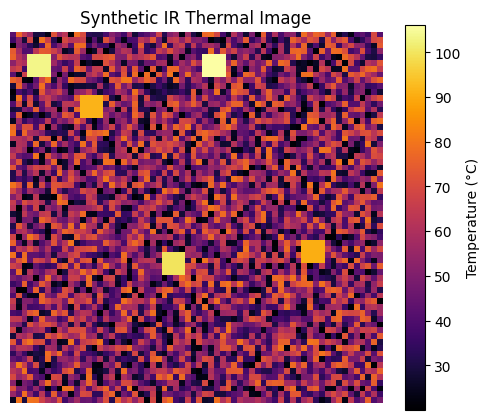

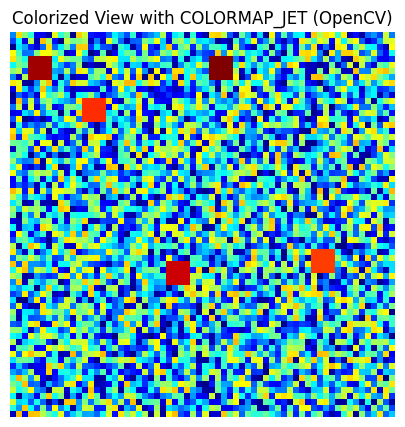

In [7]:
# I'm generating random thermal data between 20°C and 80°C
np.random.seed(42)  # Just to make sure the results are the same every time I run this
thermal_data = np.random.uniform(low=20, high=80, size=(64, 64))

# I'm adding some hot spots (anomalies) with higher temps like 90-110°C
for _ in range(5):
    x = np.random.randint(5, 59)
    y = np.random.randint(5, 59)
    thermal_data[x-2:x+2, y-2:y+2] = np.random.uniform(90, 110)

# Now I’ll show the thermal data as a heatmap using matplotlib
plt.figure(figsize=(6, 5))
plt.imshow(thermal_data, cmap='inferno')
plt.colorbar(label="Temperature (°C)")
plt.title("Synthetic IR Thermal Image")
plt.axis('off')
plt.show()

# Let me normalize the values to 0–255 so I can use OpenCV’s colormap
thermal_normalized = cv2.normalize(thermal_data, None, 0, 255, cv2.NORM_MINMAX)
thermal_uint8 = thermal_normalized.astype(np.uint8)

# I'm applying a JET colormap to make it more visually striking
thermal_colormap = cv2.applyColorMap(thermal_uint8, cv2.COLORMAP_JET)

# And here I convert BGR to RGB so matplotlib can display it correctly
plt.figure(figsize=(6, 5))
plt.imshow(cv2.cvtColor(thermal_colormap, cv2.COLOR_BGR2RGB))
plt.title("Colorized View with COLORMAP_JET (OpenCV)")
plt.axis('off')
plt.show()


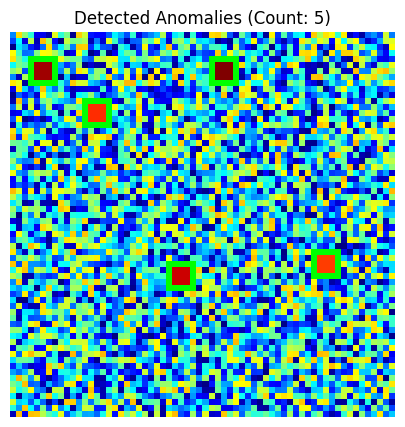

In [8]:
# I'm setting a threshold for anomalies: mean + 2 * std deviation
mean_temp = np.mean(thermal_data)
std_temp = np.std(thermal_data)
threshold = mean_temp + 2 * std_temp

# I create a binary mask where pixels hotter than the threshold are anomalies
anomaly_mask = thermal_data > threshold

# I label connected anomaly regions (so I can draw boxes around them)
labeled_array, num_features = scipy.ndimage.label(anomaly_mask)
anomaly_coords = scipy.ndimage.find_objects(labeled_array)

# I apply colormap again (same as before) to get a background image
thermal_normalized = cv2.normalize(thermal_data, None, 0, 255, cv2.NORM_MINMAX)
thermal_uint8 = thermal_normalized.astype(np.uint8)
thermal_colormap = cv2.applyColorMap(thermal_uint8, cv2.COLORMAP_JET)

# I'm drawing rectangles around the anomaly areas
output = thermal_colormap.copy()
for obj in anomaly_coords:
    y1, y2 = obj[0].start, obj[0].stop
    x1, x2 = obj[1].start, obj[1].stop
    cv2.rectangle(output, (x1, y1), (x2, y2), (0, 255, 0), 1)  # green box

# I'm showing the final result with anomalies highlighted
plt.figure(figsize=(6, 5))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Anomalies (Count: {num_features})")
plt.axis('off')
plt.show()


In [12]:
# I’ll make sure the output folder exists
os.makedirs("outputs", exist_ok=True)

# I’m saving the anomaly-marked image as PNG
output_path = "outputs/thermal_with_anomalies.png"
cv2.imwrite(output_path, output)

# Now I'm preparing a simple report for this image
report = {
    "image_name": "thermal_with_anomalies.png",
    "mean_temperature": round(mean_temp, 2),
    "std_deviation": round(std_temp, 2),
    "threshold_used": round(threshold, 2),
    "anomaly_count": num_features
}

# I save this as a one-row CSV report
report_df = pd.DataFrame([report])
report_df.to_csv("outputs/anomaly_report.csv", index=False)

# I show the report in notebook too, just to confirm
print(" Report saved to 'outputs/anomaly_report.csv':")
print(report_df)

 Report saved to 'outputs/anomaly_report.csv':
                   image_name  mean_temperature  std_deviation  \
0  thermal_with_anomalies.png             50.86          18.49   

   threshold_used  anomaly_count  
0           87.85              5  


In [13]:
# I'm defining a function to generate thermal data with anomalies
def generate_synthetic_thermal(shape=(64, 64), anomaly_count=5):
    data = np.random.uniform(low=20, high=80, size=shape)
    for _ in range(anomaly_count):
        x = np.random.randint(5, shape[0] - 5)
        y = np.random.randint(5, shape[1] - 5)
        data[x-2:x+2, y-2:y+2] = np.random.uniform(90, 110)
    return data

# This function handles visualization and anomaly detection
def process_and_save_image(index, thermal_data):
    mean_temp = np.mean(thermal_data)
    std_temp = np.std(thermal_data)
    threshold = mean_temp + 2 * std_temp

    anomaly_mask = thermal_data > threshold
    labeled_array, num_features = scipy.ndimage.label(anomaly_mask)
    anomaly_coords = scipy.ndimage.find_objects(labeled_array)

    thermal_norm = cv2.normalize(thermal_data, None, 0, 255, cv2.NORM_MINMAX)
    thermal_uint8 = thermal_norm.astype(np.uint8)
    colormap = cv2.applyColorMap(thermal_uint8, cv2.COLORMAP_JET)

    output = colormap.copy()
    for obj in anomaly_coords:
        y1, y2 = obj[0].start, obj[0].stop
        x1, x2 = obj[1].start, obj[1].stop
        cv2.rectangle(output, (x1, y1), (x2, y2), (0, 255, 0), 1)

    image_name = f"thermal_{index:02d}.png"
    image_path = f"outputs/{image_name}"
    cv2.imwrite(image_path, output)

    report = {
        "image_name": image_name,
        "mean_temperature": round(mean_temp, 2),
        "std_deviation": round(std_temp, 2),
        "threshold_used": round(threshold, 2),
        "anomaly_count": num_features
    }

    return report

# I make sure the output folder exists
os.makedirs("outputs", exist_ok=True)

# I'm processing multiple synthetic images
all_reports = []
for i in range(5):  # number of images
    synthetic_data = generate_synthetic_thermal()
    report = process_and_save_image(i + 1, synthetic_data)
    all_reports.append(report)

# I'm saving all results to CSV
df = pd.DataFrame(all_reports)
df.to_csv("outputs/anomaly_report_all.csv", index=False)

# I show the summary table here
print(" Summary report saved to outputs/anomaly_report_all.csv")
df


 Summary report saved to outputs/anomaly_report_all.csv


,image_name,mean_temperature,std_deviation,threshold_used,anomaly_count
0,thermal_01.png,51.21,18.30,87.81,4
1,thermal_02.png,50.89,18.62,88.13,5
2,thermal_03.png,50.68,18.48,87.64,5
3,thermal_04.png,50.83,18.30,87.43,4
4,thermal_05.png,51.44,18.57,88.58,4
